In [8]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import copy

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

In [9]:
import csv
freq = {}

with open("results.csv", "r", newline="") as file:
    reader = csv.reader(file)

    next(reader)

    for row in reader:
        edge = tuple(map(int, row[0].split('-')))
        frequency = int(row[1])

        freq[edge] = frequency

In [10]:
def get_edge_sublists_sorted_by_frequency(edge_frequency):
    sorted_edges = sorted(edge_frequency.items(), key=lambda item: item[1], reverse=True)
    values = [i[1] for i in sorted_edges]
    sorted_edges = [i[0] for i in sorted_edges]
    sorted_edges = torch.tensor(sorted_edges)
    sublists = torch.split(sorted_edges, 264)
    values = torch.tensor(values)
    values = torch.split(values, 264)
    return sublists, values


sublists, values = get_edge_sublists_sorted_by_frequency(freq)
print(len(sublists))

20


In [11]:
for i in values:
    print(i.float().mean().item())

18.814393997192383
13.988636016845703
12.246212005615234
11.053030014038086
10.015151977539062
9.28787899017334
9.0
8.018939018249512
7.73106050491333
7.0
6.541666507720947
6.0
5.681818008422852
5.0
4.76893949508667
4.0
3.6363637447357178
3.0
2.409090995788574
1.2941176891326904


In [12]:
def make_undirected(sublists):
    res = []
    for s in sublists:
        flipped = s.flip(dims=[1])
        combined = torch.cat((s, flipped), dim=0)
        res.append(combined)
    return res

sublists = make_undirected(sublists)

In [13]:
def generate_perturbations(data, edges_to_remove):
    data = copy.deepcopy(data)
    edges = data.edge_index.t()
    
    edges_set = set(map(tuple, edges.numpy()))
    remove_set = set(map(tuple, edges_to_remove.numpy()))

    keep_edges = edges_set - remove_set
    keep_edges = torch.tensor(list(keep_edges)).t()
    data.edge_index = keep_edges
    
    return data

In [14]:
perturbed_graphs = []

for edges_to_remove in sublists:
    print(edges_to_remove)
    perturbed_graphs.append(generate_perturbations(data, edges_to_remove))

print(len(perturbed_graphs))
print(perturbed_graphs[1].edge_index.shape)

tensor([[ 143, 1701],
        [1241, 1701],
        [ 306, 1367],
        ...,
        [1702, 1240],
        [2238,  706],
        [1443,  963]])
tensor([[ 279, 2423],
        [  33,  698],
        [  33,  911],
        ...,
        [ 904,  132],
        [1276, 1022],
        [ 623,  444]])
tensor([[ 316, 1297],
        [ 310, 1272],
        [ 310, 1331],
        ...,
        [1956, 1954],
        [2109, 1975],
        [2446, 1712]])
tensor([[1749, 2446],
        [ 871, 1229],
        [ 871, 2530],
        ...,
        [2163, 1502],
        [1975, 1421],
        [2246, 2243]])
tensor([[1428, 2524],
        [1986, 1987],
        [1889, 1890],
        ...,
        [2034, 1889],
        [ 718,  438],
        [1051,  911]])
tensor([[ 444, 2464],
        [ 515, 2464],
        [1507, 1645],
        ...,
        [1165,  537],
        [1698,  537],
        [1907,  210]])
tensor([[ 405, 2059],
        [1906, 2059],
        [ 148,  381],
        ...,
        [1975, 1676],
        [1421, 1420],
 

In [15]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      out = F.softmax(out, dim=1)
      pred = out.argmax(dim=1)
      correct = pred[mask] == data.y[mask]
      acc = int(correct.sum()) / int(mask.sum())
      return acc

In [17]:
for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.9438, Val: 0.3780, Test: 0.4090
Epoch: 002, Loss: 1.9364, Val: 0.5680, Test: 0.5890
Epoch: 003, Loss: 1.9266, Val: 0.6180, Test: 0.6180
Epoch: 004, Loss: 1.9165, Val: 0.6200, Test: 0.6210
Epoch: 005, Loss: 1.9050, Val: 0.6620, Test: 0.6550
Epoch: 006, Loss: 1.8944, Val: 0.7160, Test: 0.7260
Epoch: 007, Loss: 1.8821, Val: 0.7680, Test: 0.7490
Epoch: 008, Loss: 1.8728, Val: 0.7700, Test: 0.7710
Epoch: 009, Loss: 1.8592, Val: 0.7940, Test: 0.7860
Epoch: 010, Loss: 1.8463, Val: 0.7960, Test: 0.7880
Epoch: 011, Loss: 1.8381, Val: 0.7980, Test: 0.7830
Epoch: 012, Loss: 1.8246, Val: 0.7960, Test: 0.7790
Epoch: 013, Loss: 1.8105, Val: 0.7960, Test: 0.7790
Epoch: 014, Loss: 1.7909, Val: 0.7920, Test: 0.7770
Epoch: 015, Loss: 1.7859, Val: 0.7880, Test: 0.7760
Epoch: 016, Loss: 1.7616, Val: 0.7860, Test: 0.7760
Epoch: 017, Loss: 1.7493, Val: 0.7880, Test: 0.7780
Epoch: 018, Loss: 1.7317, Val: 0.7900, Test: 0.7760
Epoch: 019, Loss: 1.7235, Val: 0.7900, Test: 0.7770
Epoch: 020, 

In [18]:
def get_logit_diff(perturbed_edge_index):
    model.eval()
    out_orig = model(data.x, data.edge_index)
    out_perturb = model(data.x, perturbed_edge_index)
    logit_diff = out_orig - out_perturb
    l2_norm = torch.norm(logit_diff, p=2) / torch.norm(data.x, p=2)
    return l2_norm

logit_diffs = []
for perturbed_graph in perturbed_graphs:
    logit_diffs.append(get_logit_diff(perturbed_graph.edge_index).item())

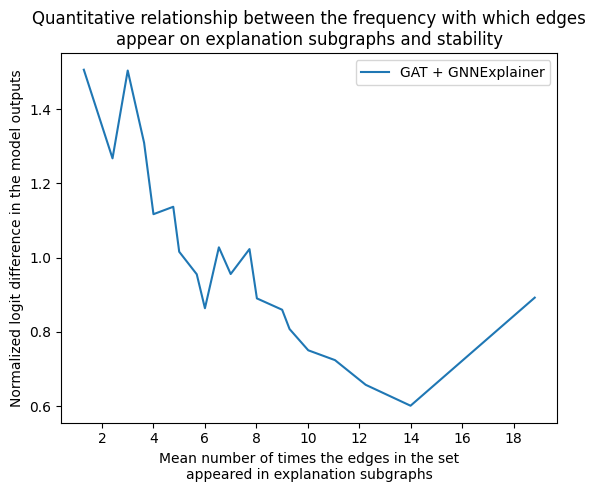

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot([i.float().mean().item() for i in values], logit_diffs, label="GAT + GNNExplainer")
plt.title('Quantitative relationship between the frequency with which edges\nappear on explanation subgraphs and stability')
plt.xlabel('Mean number of times the edges in the set\nappeared in explanation subgraphs')
plt.ylabel('Normalized logit difference in the model outputs')
plt.legend()

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

In [50]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of val nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of val nodes: 500
Number of test nodes: 1000
